# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Загрузка и подключение библиотек

In [1]:
!pip install --upgrade scikit-learn -q
!pip install phik -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from sklearn.linear_model import LinearRegression

Загрузка данных

In [3]:
try:
    data=pd.read_csv('/datasets/autos.csv')
except FileNotFoundError:
    data=pd.read_csv('autos.csv')

Просмотр информации о данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Вывод первыъ строчек данных

In [5]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Приведение названий столбцов к "змеиному регистру"

In [6]:
data=data.rename(columns={'DateCrawled':'date_crawled', 
                     'Price':'price', 
                     'VehicleType':'vehicle_type', 
                     'RegistrationYear':'registration_year', 
                     'Gearbox':'gearbox', 
                     'Power':'power', 
                     'Model':'model', 
                     'Kilometer':'kilometer', 
                     'RegistrationMonth':'registration_month', 
                     'FuelType':'fuel_type', 
                     'Brand':'brand', 
                     'Repaired':'repaired', 
                     'DateCreated':'date_created', 
                     'NumberOfPictures':'number_of_pictures', 
                     'PostalCode':'postal_code', 
                     'LastSeen':'last_seen'}
           )
data.head(1)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57


Вывод количество пропусков по столбцам

In [7]:
i=0
for col in data.columns:
    print(i, col, data[col].isnull().sum())
    i+=1

0 date_crawled 0
1 price 0
2 vehicle_type 37490
3 registration_year 0
4 gearbox 19833
5 power 0
6 model 19705
7 kilometer 0
8 registration_month 0
9 fuel_type 32895
10 brand 0
11 repaired 71154
12 date_created 0
13 number_of_pictures 0
14 postal_code 0
15 last_seen 0


Количество дубликатов в data

In [8]:
data.duplicated().sum()

4

Удаление дубликатов из данных

In [9]:
data=data.drop_duplicates()

Просмотр уникальных значений на наличие неявных дубликатов (так, по крайней мере, было задумано)

In [10]:
for col in data.columns:
    print(col, data[col].unique())

date_crawled ['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...
 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12']
price [  480 18300  9800 ... 12395 18429 10985]
vehicle_type [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
registration_year [1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290 2500 1930 1001 9450 1944 1943 1934 1938 1688 2800
 1253 1928 1919 5555 5600 1600 2222 1039 9996 1300 8455 19

last_seen ['2016-04-07 03:16:57' '2016-04-07 01:46:50' '2016-04-05 12:47:46' ...
 '2016-03-19 20:44:43' '2016-03-29 10:17:23' '2016-03-21 10:42:49']


Изменение типа данных в столбиках 'date_crawled', 'date_created', 'last_seen' на datetime64

In [11]:
data['date_crawled']=pd.to_datetime(data['date_crawled'], format='%Y-%m-%d %H:%M:%S')
data['date_created']=pd.to_datetime(data['date_created'], format='%Y-%m-%d %H:%M:%S')
data['last_seen']=pd.to_datetime(data['last_seen'], format='%Y-%m-%d %H:%M:%S')

Просмотр информации о данных после изменения типа

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354365 non-null  datetime64[ns]
 1   price               354365 non-null  int64         
 2   vehicle_type        316875 non-null  object        
 3   registration_year   354365 non-null  int64         
 4   gearbox             334532 non-null  object        
 5   power               354365 non-null  int64         
 6   model               334660 non-null  object        
 7   kilometer           354365 non-null  int64         
 8   registration_month  354365 non-null  int64         
 9   fuel_type           321470 non-null  object        
 10  brand               354365 non-null  object        
 11  repaired            283211 non-null  object        
 12  date_created        354365 non-null  datetime64[ns]
 13  number_of_pictures  354365 non-nul

Гистограмма цен на автомобили

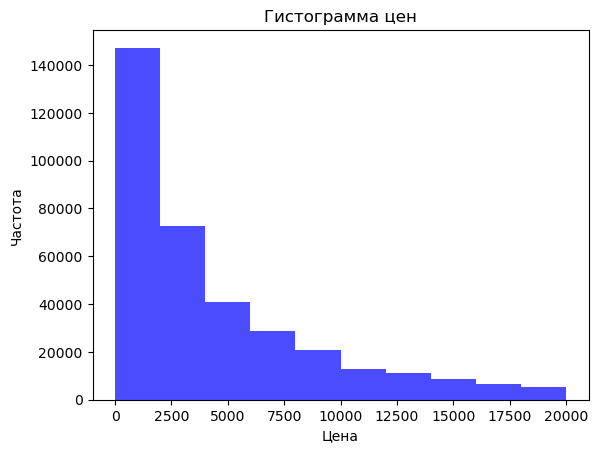

In [13]:
plt.hist(data['price'], bins=10, color='blue', alpha=0.7)
plt.title('Гистограмма цен')
plt.xlabel('Цена')
plt.ylabel('Частота');

График боксплот для цен на автомобиль

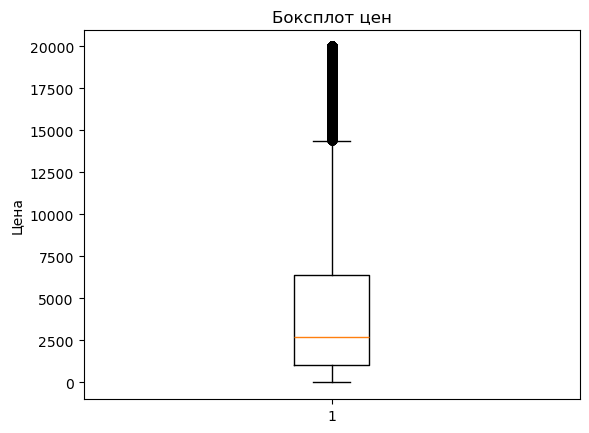

In [14]:
plt.boxplot(data['price'])
plt.title('Боксплот цен')
plt.ylabel('Цена');

Могу предположить, что с машинами, которые стоят до 100 евро (на данный момент 10000 руб.), что-то не так. Особенно с марками по типу Mercedes-Benz, Volkswagen, Suzuki и т.д. Думаю, эти данные можно удалить, пока это 3,8% от всех данных.

In [15]:
data.loc[data['price']<100]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26,0,56412,2016-03-27 17:43:34
59,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29,0,53721,2016-04-06 01:44:38
89,2016-03-28 09:37:01,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no,2016-03-28,0,40589,2016-04-06 12:15:54
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19,0,21698,2016-04-01 08:47:05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354238,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,NaN,2016-03-20,0,33659,2016-04-06 18:45:23
354248,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,NaN,2016-03-24,0,42329,2016-04-07 05:17:24
354277,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10,0,22559,2016-03-12 23:46:32
354309,2016-03-09 22:37:41,99,small,1999,manual,60,arosa,150000,1,petrol,seat,yes,2016-03-09,0,91301,2016-04-06 22:15:32


Удаление информации о машинах стоимость меньше 100

In [16]:
data = data[data['price'] >= 100]

Заполнение пропусков в столбце vehicle_type на Unknown и вывод информации

In [17]:
data['vehicle_type'].fillna('Unknown', inplace=True)
data['vehicle_type'].isnull().sum()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 341051 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        341051 non-null  datetime64[ns]
 1   price               341051 non-null  int64         
 2   vehicle_type        341051 non-null  object        
 3   registration_year   341051 non-null  int64         
 4   gearbox             324737 non-null  object        
 5   power               341051 non-null  int64         
 6   model               324018 non-null  object        
 7   kilometer           341051 non-null  int64         
 8   registration_month  341051 non-null  int64         
 9   fuel_type           312702 non-null  object        
 10  brand               341051 non-null  object        
 11  repaired            276694 non-null  object        
 12  date_created        341051 non-null  datetime64[ns]
 13  number_of_pictures  341051 non-nul

C:\Users\User\AppData\Local\Temp\ipykernel_14484\728614349.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['vehicle_type'].fillna('Unknown', inplace=True)


<br/>    
<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b>👋:</b> Не очень понимаю как год регистрации может быть в промежутке от 1000 до 9999
</div> 

Просмотр уникальных значений в солбце registration_year

In [18]:
sorted(data['registration_year'].unique())

[1000,
 1001,
 1039,
 1111,
 1234,
 1255,
 1300,
 1400,
 1500,
 1600,
 1602,
 1800,
 1910,
 1923,
 1925,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2066,
 2200,
 2222,
 2290,
 2500,
 2800,
 2900,
 3000,
 3200,
 3700,
 3800,
 4000,
 4100,
 4500,
 4800,
 5000,
 5300,
 5555,
 5600,
 5900,
 5911,
 6000,
 7000,
 7100,
 7800,
 8200,
 8500,
 8888,
 9000,
 9450,
 9999]

Это я пытался понять почему год регистрации находится в данном диапазоне

In [19]:
data.loc[data['registration_year']==1000]
data.loc[data['registration_year']==9999]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
17271,2016-03-23 16:43:29,700,Unknown,9999,NaN,0,other,10000,0,NaN,opel,NaN,2016-03-23,0,21769,2016-04-05 20:16:15
28390,2016-04-05 08:57:08,799,Unknown,9999,NaN,0,3er,10000,4,petrol,bmw,NaN,2016-04-05,0,72116,2016-04-07 12:17:50
28965,2016-04-04 22:54:47,18000,Unknown,9999,NaN,0,a_klasse,10000,0,petrol,mercedes_benz,NaN,2016-04-04,0,51379,2016-04-07 02:44:52
29426,2016-03-23 21:52:25,7999,Unknown,9999,NaN,0,kaefer,10000,0,NaN,volkswagen,NaN,2016-03-23,0,47638,2016-04-06 03:46:40
128677,2016-03-14 14:51:56,1550,Unknown,9999,NaN,95,NaN,10000,0,NaN,volkswagen,NaN,2016-03-14,0,35288,2016-03-16 04:48:21
149151,2016-04-02 18:57:33,400,Unknown,9999,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,2016-04-02,0,26441,2016-04-02 18:57:33
167937,2016-03-23 13:49:51,1000,Unknown,9999,NaN,0,NaN,10000,0,NaN,mazda,NaN,2016-03-23,0,40822,2016-03-23 13:49:51
200525,2016-03-22 15:56:52,850,Unknown,9999,NaN,0,NaN,10000,0,NaN,mazda,NaN,2016-03-22,0,40822,2016-03-22 15:56:52
217111,2016-03-26 13:55:09,850,Unknown,9999,NaN,0,3er,10000,0,NaN,bmw,no,2016-03-26,0,77746,2016-03-31 09:15:47
227462,2016-03-14 12:51:55,2850,Unknown,9999,NaN,0,other,10000,0,NaN,fiat,NaN,2016-03-14,0,17335,2016-04-05 13:15:26


Оставлю это нетронутым

Вывод строк из столбика gearbox в которых есть пропуски

In [20]:
data.loc[data['gearbox'].isna()]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11,0,24148,2016-03-19 08:46:47
16,2016-04-01 12:46:46,300,Unknown,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01,0,38871,2016-04-01 12:46:46
32,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15,0,44145,2016-03-17 18:17:43
37,2016-03-28 17:50:15,1500,Unknown,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28,0,46483,2016-03-30 09:18:02
69,2016-04-01 11:56:40,1200,coupe,2001,NaN,0,astra,150000,0,NaN,opel,NaN,2016-04-01,0,47249,2016-04-07 08:46:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354288,2016-03-16 13:36:25,3300,wagon,2006,NaN,0,touran,150000,7,gasoline,volkswagen,NaN,2016-03-16,0,12057,2016-03-17 12:17:07
354305,2016-04-03 13:46:24,3500,Unknown,1995,NaN,0,polo,150000,0,NaN,volkswagen,NaN,2016-04-03,0,74579,2016-04-05 12:44:38
354329,2016-03-30 20:55:30,350,small,1996,NaN,65,punto,150000,0,NaN,fiat,NaN,2016-03-30,0,25436,2016-04-07 13:50:41
354338,2016-03-31 19:52:33,180,Unknown,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,2016-03-31,0,41470,2016-04-06 14:18:04


Поиск колонок которые совпадают пропусками с gearbox. Если совпадений будет много значит строчки можно будет удалить.

In [21]:
for col in data.columns:
    if col != 'gearbox':
        count = data.loc[data['gearbox'].isna() & data[col].isna()].shape[0]
        print(f"Количество совпадающих пропусков со столбцом: '{col}': {count}")

Количество совпадающих пропусков со столбцом: 'date_crawled': 0
Количество совпадающих пропусков со столбцом: 'price': 0
Количество совпадающих пропусков со столбцом: 'vehicle_type': 0
Количество совпадающих пропусков со столбцом: 'registration_year': 0
Количество совпадающих пропусков со столбцом: 'power': 0
Количество совпадающих пропусков со столбцом: 'model': 2762
Количество совпадающих пропусков со столбцом: 'kilometer': 0
Количество совпадающих пропусков со столбцом: 'registration_month': 0
Количество совпадающих пропусков со столбцом: 'fuel_type': 6274
Количество совпадающих пропусков со столбцом: 'brand': 0
Количество совпадающих пропусков со столбцом: 'repaired': 9718
Количество совпадающих пропусков со столбцом: 'date_created': 0
Количество совпадающих пропусков со столбцом: 'number_of_pictures': 0
Количество совпадающих пропусков со столбцом: 'postal_code': 0
Количество совпадающих пропусков со столбцом: 'last_seen': 0


Удаление пропусков еще 4.6% (суммарно удалено 8.4%)

In [22]:
data.dropna(subset=['gearbox'], inplace=True)

Вывод информации после проделанной операции

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 324737 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        324737 non-null  datetime64[ns]
 1   price               324737 non-null  int64         
 2   vehicle_type        324737 non-null  object        
 3   registration_year   324737 non-null  int64         
 4   gearbox             324737 non-null  object        
 5   power               324737 non-null  int64         
 6   model               310466 non-null  object        
 7   kilometer           324737 non-null  int64         
 8   registration_month  324737 non-null  int64         
 9   fuel_type           302662 non-null  object        
 10  brand               324737 non-null  object        
 11  repaired            270098 non-null  object        
 12  date_created        324737 non-null  datetime64[ns]
 13  number_of_pictures  324737 non-nul

Вывод отсортированного списка уникальных значений в столбце power

In [24]:
sorted(data['power'].unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


Описательная статистика 

In [25]:
data['power'].describe()

count    324737.000000
mean        114.983821
std         188.534396
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

Можно заметить очень высокое максимальное значение и непонятный минимум

Вывод строк где мощность равна нулю

In [26]:
data.loc[data['power']==0]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,Unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
54,2016-03-17 07:56:40,4700,wagon,2005,manual,0,signum,150000,0,NaN,opel,no,2016-03-17,0,88433,2016-04-04 04:17:32
55,2016-03-26 10:39:35,550,wagon,1999,manual,0,astra,150000,8,gasoline,opel,yes,2016-03-26,0,56759,2016-04-01 23:17:27
70,2016-03-08 01:36:42,800,small,1993,manual,0,polo,150000,3,petrol,volkswagen,no,2016-03-08,0,8258,2016-04-05 23:46:00
90,2016-03-23 11:53:21,2400,sedan,2003,manual,0,a4,150000,9,gasoline,audi,NaN,2016-03-23,0,40210,2016-03-23 11:53:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354332,2016-03-13 15:45:22,7900,bus,2007,manual,0,b_klasse,125000,1,petrol,mercedes_benz,no,2016-03-13,0,30519,2016-03-27 00:18:05
354335,2016-04-04 14:41:28,390,small,1997,auto,0,corsa,100000,6,petrol,opel,yes,2016-04-04,0,17509,2016-04-06 15:46:11
354336,2016-03-05 18:57:45,3299,Unknown,2005,auto,0,outlander,150000,4,petrol,mitsubishi,NaN,2016-03-05,0,17034,2016-03-06 04:17:37
354346,2016-03-07 17:06:35,2600,Unknown,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN,2016-03-07,0,61169,2016-03-08 21:28:38


Просмотр информации о машине с невероятным количеством сил

In [27]:
data.loc[data['power']==20000]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
219584,2016-03-09 15:43:53,4300,coupe,1999,auto,20000,clk,150000,1,petrol,mercedes_benz,no,2016-03-09,0,19406,2016-03-30 08:47:08


Сравнил с реальной мощностью данной машины и могу предположить что здесь ошиблись в 100 раз

Далее выборочно проверю машины с огромным количеством лошадиных сил

In [28]:
data.loc[data['power']==12512]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
253791,2016-03-17 16:55:13,300,Unknown,2017,manual,12512,vectra,150000,0,NaN,opel,yes,2016-03-17,0,88690,2016-03-23 05:20:52
292167,2016-03-21 12:49:22,2000,bus,2003,manual,12512,zafira,150000,12,petrol,opel,NaN,2016-03-21,0,52072,2016-04-06 07:45:32
346639,2016-03-25 12:55:36,1300,sedan,2000,manual,12512,carisma,150000,9,petrol,mitsubishi,NaN,2016-03-25,0,42105,2016-04-06 14:44:53


Аналогичная ситуация по всем трем машинам

In [29]:
data.loc[data['power']==17019]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
187330,2016-03-17 19:50:23,1749,wagon,1989,manual,17019,3er,5000,12,petrol,bmw,NaN,2016-03-17,0,89542,2016-03-26 00:46:59


В данном случае таккая же ошибка

Делаю вывод что машины у которых мощность измеряется в десятках тысяч лошадиных сил везде ондна и та же ошибка. Значит можем разделить значения на 100

Далее хочу проверить машины которые находятся в диапазоне 2000-10000

In [30]:
data.loc[data['power']==7518]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
341320,2016-03-29 21:40:33,1899,other,2006,manual,7518,berlingo,125000,11,petrol,citroen,yes,2016-03-29,0,89428,2016-03-31 15:17:03


Опять в сто раз

In [31]:
data.loc[data['power']==9007]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
277113,2016-03-19 16:49:47,2890,bus,2005,manual,9007,c_max,150000,2,petrol,ford,no,2016-03-19,0,25813,2016-03-19 16:49:47


Тут не понятно реальная мощность 125-145 л.с

In [32]:
data.loc[data['power']==3454]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
131401,2016-03-22 16:38:44,4500,sedan,2001,auto,3454,e_klasse,150000,6,petrol,mercedes_benz,NaN,2016-03-22,0,67433,2016-03-25 08:45:20


Реальная мощность 184-204. Пока 2 не очень приятных примера с которыми не знаю что делать. По сути я хочу найти границу где люди ошиблись в 100 раз и 10

In [33]:
data.loc[data['power']==2000]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
172462,2016-03-20 20:51:27,3000,wagon,2002,manual,2000,other,5000,2,gasoline,citroen,no,2016-03-20,0,50127,2016-03-24 14:17:59
301617,2016-04-04 21:39:53,10500,sedan,2006,manual,2000,golf,150000,10,petrol,volkswagen,no,2016-04-04,0,21502,2016-04-07 00:15:34
353493,2016-04-02 20:54:21,12500,Unknown,2017,manual,2000,other,60000,0,gasoline,chrysler,no,2016-04-02,0,44145,2016-04-06 21:44:39


Фольцваген отличается в 20 раз остальные примерно так же обнаружена новая грань люди ошиблись в 20 раз это очень странная ошибка

Я выделил четыре группы:
- 1000-2000 разница в 10 раз
- 2000-4000 разница в 20 раз
- 4000-7500 разница в 50 раз
- 7500-20000 разница в 100 раз

А дальше идет разнообразие ошибок 
Значение, где мощность равна нулю, как будто, можно удалить. Но процент удаленных данных уже 8.4%, а по правильному это число не может превышать 10% данных. Я не знаю как сделать по другому.

Еще 7% данных было удалено итого суммарно 15,4%

In [34]:
data = data[data['power'] != 0]

Информация о данных

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300008 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        300008 non-null  datetime64[ns]
 1   price               300008 non-null  int64         
 2   vehicle_type        300008 non-null  object        
 3   registration_year   300008 non-null  int64         
 4   gearbox             300008 non-null  object        
 5   power               300008 non-null  int64         
 6   model               288435 non-null  object        
 7   kilometer           300008 non-null  int64         
 8   registration_month  300008 non-null  int64         
 9   fuel_type           281930 non-null  object        
 10  brand               300008 non-null  object        
 11  repaired            256106 non-null  object        
 12  date_created        300008 non-null  datetime64[ns]
 13  number_of_pictures  300008 non-nul

Пытаемся исправить выделенные ранее группы

In [36]:
range_1_2 = (data['power'] > 1000) & (data['power'] <= 2000)
range_2_4 = (data['power'] > 2000) & (data['power'] <= 4000)
range_4_7 = (data['power'] > 4000) & (data['power'] <= 7500)
range_7_20 = (data['power'] > 7500) & (data['power'] <= 20000)
data.loc[range_1_2, 'power'] /= 10
data.loc[range_2_4, 'power'] /= 20
data.loc[range_4_7, 'power'] /= 50
data.loc[range_7_20, 'power'] /= 100
data['power'] = data['power'].round()
data['power']=data['power'].astype(int)

C:\Users\User\AppData\Local\Temp\ipykernel_14484\224980381.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[139.8 100.1 140.  177.9 175.3 124.  170.4 190.  120.  199.3 101.1 199.9
 105.6 165.9 162.5 177.9 136.7 159.7 109.  100.1 136.  106.2 140.  102.4
 179.6 100.2 178.  180.  139.9 130.  125.6 165.3 150.  120.2 100.1 143.6
 140.5 128.8 105.5 111.5 110.5 122.3 196.8 192.  116.4 150.1 175.3 170.3
 199.5 100.5 140.3 180.1 131.2 193.7 190.  160.  160.  140.3 178.1 150.3
 159.6 150.6 130.  159.8 136.3 105.4 133.9 115.1 177.1 178.1 159.8 200.
 152.1 100.1 199.8 159.8 199.8 159.8 123.  189.5 180.  131.7 159.5 140.
 119.9 150.  159.8 116.2 112.  189.6 139.9 101.1 130.  140.1 102.1 150.
 187.  125.  180.  115.8 150.  127.5 180.  101.6 122.1 180.  136.2 159.5
 199.5 198.6 100.3 160.  143.2 101.7 139.4 199.2 143.3 170.1 150.2 123.9
 139.  116.  135.1 136.3 178.3 102.1 114.9 179.3 132.4 101.6 180.  101.1
 129.9

Описательная статистика после изменения

In [37]:
data['power'].describe()

count    300008.000000
mean        120.831248
std          54.616647
min           1.000000
25%          77.000000
50%         111.000000
75%         150.000000
max        1000.000000
Name: power, dtype: float64

Вывод отсортированного списка 

In [38]:
data['power'].sort_values(inplace=False)

52952        1
268929       1
94319        1
33223        1
73846        1
          ... 
260366     999
223945     999
209422    1000
52323     1000
119692    1000
Name: power, Length: 300008, dtype: int32

Просмотр значений которые ниже или равно 20 лошадиным сил

In [39]:
data.loc[data['power']<=20]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
431,2016-03-20 20:45:27,3950,small,2004,auto,5,NaN,70000,5,gasoline,sonstige_autos,no,2016-03-20,0,90562,2016-04-03 04:17:08
4637,2016-03-21 00:36:23,870,wagon,2000,manual,16,focus,150000,0,NaN,ford,no,2016-03-21,0,66693,2016-03-21 08:40:31
9561,2016-04-04 07:58:34,9000,sedan,2009,manual,2,a4,5000,12,gasoline,audi,NaN,2016-04-04,0,12045,2016-04-06 10:17:01
11228,2016-03-10 15:39:12,9900,small,1970,manual,18,500,30000,0,petrol,fiat,no,2016-03-10,0,73278,2016-04-05 11:49:04
11852,2016-03-18 08:36:43,1999,coupe,1964,manual,10,NaN,150000,6,petrol,sonstige_autos,NaN,2016-03-18,0,74918,2016-03-21 06:47:31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348975,2016-03-19 21:53:10,1850,small,2003,auto,5,NaN,50000,3,gasoline,sonstige_autos,yes,2016-03-19,0,13347,2016-04-03 14:44:50
350502,2016-03-07 13:51:22,6200,small,1964,manual,20,NaN,40000,6,petrol,sonstige_autos,no,2016-03-07,0,41334,2016-04-07 02:44:20
353127,2016-03-26 18:53:12,8600,convertible,2012,manual,8,NaN,5000,3,gasoline,sonstige_autos,no,2016-03-26,0,82399,2016-04-06 08:17:29
353447,2016-03-27 00:46:19,2900,small,1969,manual,18,500,5000,8,petrol,fiat,no,2016-03-26,0,74076,2016-03-28 17:45:04


Удаление этих значений

In [40]:
data = data[data['power'] > 20]

Просмотр пропущенных значений в столбце model

In [41]:
data['model'].isna().sum()

11377

Удаление пропусков (это еще 3.2% суммарно 18.6%) 

In [42]:
data.dropna(subset=['model'], inplace=True)

Вывод информации о данных

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 288250 entries, 2 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        288250 non-null  datetime64[ns]
 1   price               288250 non-null  int64         
 2   vehicle_type        288250 non-null  object        
 3   registration_year   288250 non-null  int64         
 4   gearbox             288250 non-null  object        
 5   power               288250 non-null  int32         
 6   model               288250 non-null  object        
 7   kilometer           288250 non-null  int64         
 8   registration_month  288250 non-null  int64         
 9   fuel_type           273167 non-null  object        
 10  brand               288250 non-null  object        
 11  repaired            248108 non-null  object        
 12  date_created        288250 non-null  datetime64[ns]
 13  number_of_pictures  288250 non-nul

Гистограмма пробега

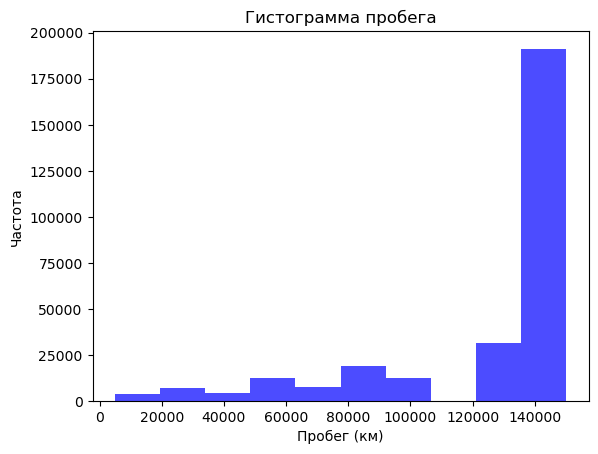

In [44]:
plt.hist(data['kilometer'], bins=10, color='blue', alpha=0.7)
plt.title('Гистограмма пробега')
plt.xlabel('Пробег (км)')
plt.ylabel('Частота');

График боксплот пробега

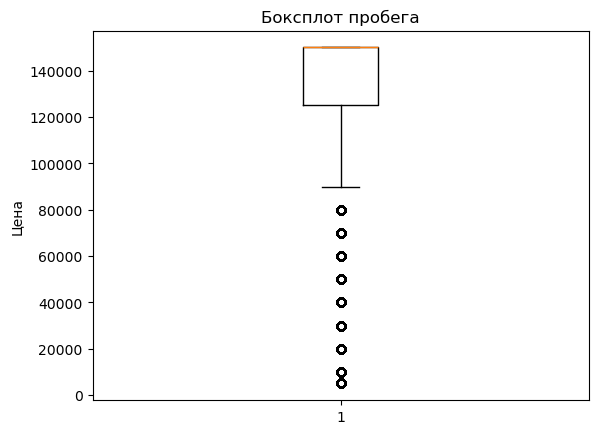

In [45]:
plt.boxplot(data['kilometer'])
plt.title('Боксплот пробега')
plt.ylabel('Цена');

Просмотр уникальных значений в столбце registration_month

In [46]:
data['registration_month'].unique()

array([ 8,  6,  7, 10,  0, 12, 11,  2,  3,  1,  4,  5,  9], dtype=int64)

Просмотр моды в столбце registration_month

In [47]:
data['registration_month'].mode()

0    3
Name: registration_month, dtype: int64

Замена нулей на моду (3)

In [48]:
data['registration_month'] = data['registration_month'].replace(0, 3)

Вывод отсортированных уникальных значений в столбике registration_month для выявления неявных дубликатов

In [49]:
sorted(data['registration_month'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

Вывод уникальных значений для столбца fuel_type

In [50]:
data['fuel_type'].unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Заполнение пропусков значением other

In [51]:
data['fuel_type']=data['fuel_type'].fillna('other')

Вывод информации после проделанных операций

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 288250 entries, 2 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        288250 non-null  datetime64[ns]
 1   price               288250 non-null  int64         
 2   vehicle_type        288250 non-null  object        
 3   registration_year   288250 non-null  int64         
 4   gearbox             288250 non-null  object        
 5   power               288250 non-null  int32         
 6   model               288250 non-null  object        
 7   kilometer           288250 non-null  int64         
 8   registration_month  288250 non-null  int64         
 9   fuel_type           288250 non-null  object        
 10  brand               288250 non-null  object        
 11  repaired            248108 non-null  object        
 12  date_created        288250 non-null  datetime64[ns]
 13  number_of_pictures  288250 non-nul

Уникальные значения в стобце brand

In [53]:
data['brand'].unique()

array(['jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford', 'mazda',
       'nissan', 'renault', 'mercedes_benz', 'opel', 'seat', 'citroen',
       'honda', 'fiat', 'mini', 'smart', 'hyundai', 'audi', 'alfa_romeo',
       'subaru', 'volvo', 'mitsubishi', 'kia', 'suzuki', 'lancia',
       'toyota', 'chevrolet', 'dacia', 'daihatsu', 'chrysler', 'jaguar',
       'daewoo', 'rover', 'porsche', 'saab', 'land_rover', 'trabant',
       'lada'], dtype=object)

Вывод уникальных значений в столбце repaired

In [54]:
data['repaired'].unique()

array([nan, 'no', 'yes'], dtype=object)

Заполнение пропусков значением Unknown

In [55]:
data['repaired'].fillna('Unknown', inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_14484\1408130855.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['repaired'].fillna('Unknown', inplace=True)


Просмотр уникальных значений после проделанной операции

In [56]:
data['repaired'].unique()

array(['Unknown', 'no', 'yes'], dtype=object)

Просмотр столбиков date_created и last_seen

In [57]:
data.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,Unknown,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01,0,67112,2016-04-05 18:18:39


С этими столбиками делать ничего не будем

In [58]:
data['number_of_pictures'].unique()

array([0], dtype=int64)

Столбец который состоит только из нулей не несет никакой информации удалим его

Удаление столбика

In [59]:
data=data.drop(['number_of_pictures'], axis=1)

Вывод информации о данных после удаления столбика

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 288250 entries, 2 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        288250 non-null  datetime64[ns]
 1   price               288250 non-null  int64         
 2   vehicle_type        288250 non-null  object        
 3   registration_year   288250 non-null  int64         
 4   gearbox             288250 non-null  object        
 5   power               288250 non-null  int32         
 6   model               288250 non-null  object        
 7   kilometer           288250 non-null  int64         
 8   registration_month  288250 non-null  int64         
 9   fuel_type           288250 non-null  object        
 10  brand               288250 non-null  object        
 11  repaired            288250 non-null  object        
 12  date_created        288250 non-null  datetime64[ns]
 13  postal_code         288250 non-nul

Вывод уникальных значений в столбце postal_code

In [61]:
len(data['postal_code'].unique())

8103

Оставим этот столбик впокое с ним все нормально

Далее проведем предварительный анализ данных

Отбор числовых признаков

In [62]:
num_columns=[]
for column in data.select_dtypes(include=['int']):
    num_columns.append(column)
num_columns

['price',
 'registration_year',
 'power',
 'kilometer',
 'registration_month',
 'postal_code']

Отбор категориальных признаков

In [63]:
str_columns=[]
for column in data.select_dtypes(include=['object']):
    str_columns.append(column)
str_columns

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

In [64]:
time_columns=[]
for column in data.select_dtypes(include=['datetime']):
    time_columns.append(column)
time_columns

['date_crawled', 'date_created', 'last_seen']

In [65]:
data[num_columns]

,price,registration_year,power,kilometer,registration_month,postal_code
2,9800,2004,163,125000,8,90480
3,1500,2001,75,150000,6,91074
4,3600,2008,69,90000,7,60437
5,650,1995,102,150000,10,33775
6,2200,2004,109,150000,8,67112
...,...,...,...,...,...,...
354361,5250,2016,150,150000,12,51371
354362,3200,2004,225,150000,5,96465
354366,1199,2000,101,125000,3,26135
354367,9200,1996,102,150000,3,87439


In [66]:
phik_matrix = data[num_columns].phik_matrix(interval_cols=num_columns)
phik_matrix

,price,registration_year,power,kilometer,registration_month,postal_code
price,1.000000,0.006799,0.475413,0.317284,0.101785,0.084408
registration_year,0.006799,1.000000,0.061956,0.042597,0.000000,0.003631
power,0.475413,0.061956,1.000000,0.077986,0.050781,0.075895
kilometer,0.317284,0.042597,0.077986,1.000000,0.035081,0.037525
registration_month,0.101785,0.000000,0.050781,0.035081,1.000000,0.033791
postal_code,0.084408,0.003631,0.075895,0.037525,0.033791,1.000000


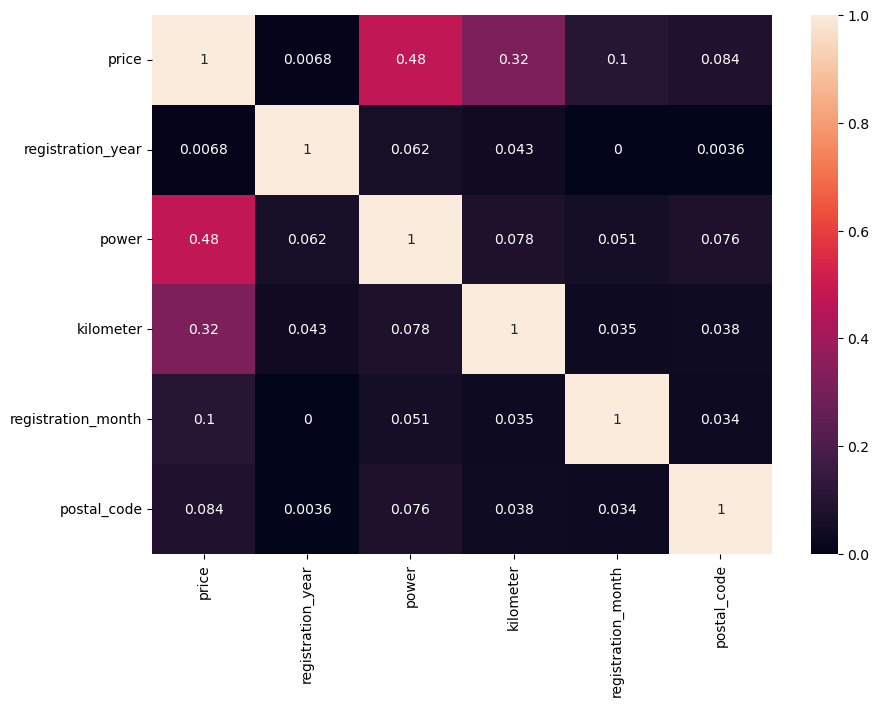

In [67]:
plt.figure(figsize=(10,7))
sns.heatmap(phik_matrix, annot=True);

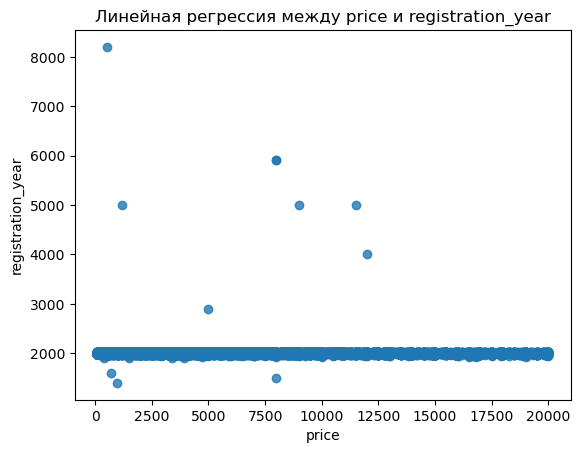

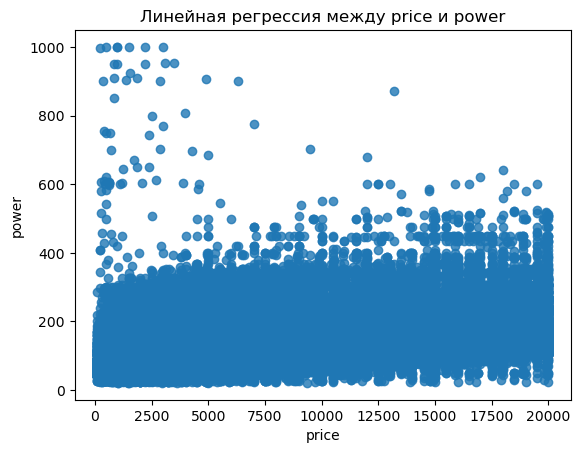

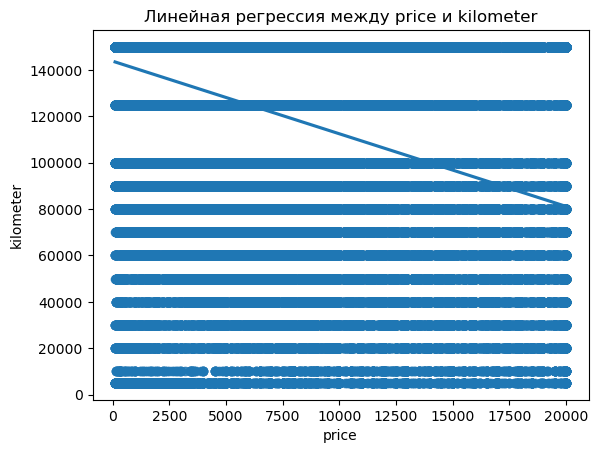

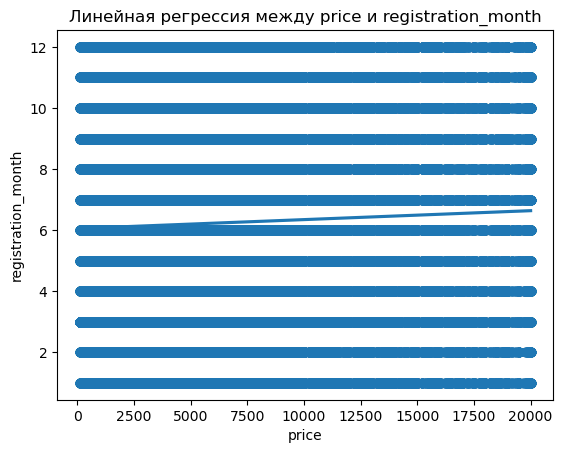

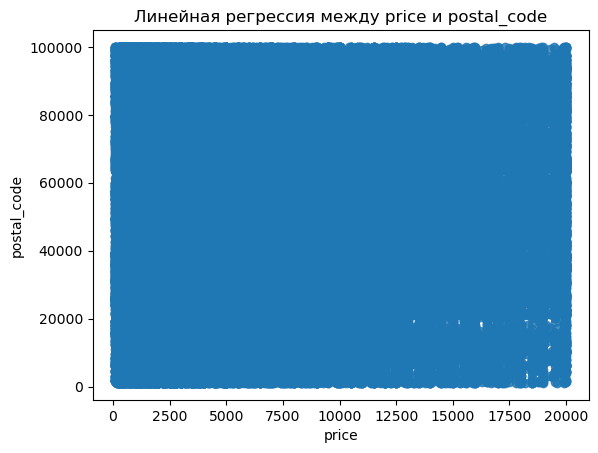

In [69]:
for col in num_columns:
    if col != 'price': 
        plt.figure()
        sns.regplot(x='price', y=col, data=data)
        plt.title(f'Линейная регрессия между price и {col}')

## Обучение моделей

## Анализ моделей

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей